# Calculation of the TOV for the mixed EOS: NSM

## Alexandra Semposki

### Date: 21 October 2024

This notebook calculates the TOV equations for given data from the EOS from Bayesian model mixing. It then compares the 20n0 and 40n0 cutoff cases, and plots them in comparison to the NICER and LIGO data in the M-R posterior.

In [20]:
# import packages
%load_ext autoreload
%autoreload 2

import pickle
import sys
import arviz as az
sys.path.append('../src/')
import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

from gp_utils import GaussianProcessRegressor2dNoise
from eos_utils import *
from tov_utils import *
from scripts import *
from pqcd_reworked import PQCD

import sys
sys.path.append('../../../TOV_Solver')
from TOV_class import TOVsolver

# set params for plotting
setup_rc_params()

# define saturation up here
n0 = 0.164

# color plotting assistance
orders = [0, 1, 2, 3]
order_labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed Model']
color_list = ['Reds', 'Blues','Purples', 'Oranges', 'Greens', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
colors = [cmap(0.7 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.5) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [369]:
# load NICER data
miller = np.loadtxt('../data/NICER_data/NICER+XMM_J0740_RM.txt')
miller_0030_2 = np.loadtxt('../data/NICER_data/J0030_2spot_RM.txt')
miller_0030_3 = np.loadtxt('../data/NICER_data/J0030_3spot_RM.txt')

# load NICER J0437 data
j0437 = np.loadtxt('../data/NICER_data/J0437_data/samples/J0437_3C50_BKG_AGN_hiMN_lowXPSI_wmrsamples.dat')

In [370]:
# load in the LIGO data from the folder
df_insens = pd.read_csv('../data/LIGO_data/EoS-insensitive_posterior_samples.dat', sep='\s+')
display(df_insens)

df_maxmass = pd.read_csv('../data/LIGO_data/Parametrized-EoS_maxmass_posterior_samples.dat', sep='\s+')
display(df_maxmass)

# convert to a dict
LIGO_insens = df_insens.to_dict('list')
LIGO_maxmass = df_maxmass.to_dict('list')

,m1_source_frame_Msun,m2_source_frame_Msun,Lambda1,Lambda2,Radius1_km,Radius2_km
0,1.543236,1.205749,97.068200,248.541197,10.730811,9.358211
1,1.482590,1.253115,19.677667,280.480973,8.186003,9.833989
2,1.541613,1.206940,31.524739,235.511540,9.149591,9.373914
3,1.562878,1.191476,49.572338,409.681755,9.951128,10.102846
4,1.656298,1.128266,27.441288,246.930128,9.602853,9.395534
...,...,...,...,...,...,...
2916,1.508332,1.232504,91.421409,229.584025,10.730333,9.901073
2917,1.602577,1.163587,59.820623,266.473512,10.058355,9.314710
2918,1.561251,1.192543,12.951990,234.310549,8.475787,9.328835
2919,1.476021,1.258401,126.699863,346.595638,10.741590,10.844589


,m1_source_frame_Msun,m2_source_frame_Msun,Lambda1,Lambda2,Radius1_km,Radius2_km
0,1.637296,1.140765,66.373870,723.523060,10.887391,11.097352
1,1.612825,1.156845,191.207304,1335.339873,12.402063,12.349246
2,1.563015,1.191614,200.526550,1156.272842,12.285450,12.501216
3,1.625307,1.148567,134.833116,1439.597356,12.141489,12.627265
4,1.625909,1.148243,177.099466,1428.281697,12.399686,12.426146
...,...,...,...,...,...,...
2391,1.456157,1.275411,271.138172,593.167994,11.771023,11.732749
2392,1.363036,1.361102,275.144868,277.559025,11.146219,11.146212
2393,1.547311,1.202998,308.382837,1352.958123,12.800400,12.770993
2394,1.379074,1.345569,253.244553,293.279550,11.077769,11.070750


In [372]:
# LIGO data
x11 = np.asarray(LIGO_maxmass['Radius1_km'])
y11 = np.asarray(LIGO_maxmass['m1_source_frame_Msun'])
x22 = np.asarray(LIGO_maxmass['Radius2_km'])
y22 = np.asarray(LIGO_maxmass['m2_source_frame_Msun'])

In [493]:
# load results from the NSM notebooks for pressure, energy density, speed of sound
with open('pres_data_20n0.pkl', 'rb') as fp:
    pressure_dict = pickle.load(fp)  # automatically in order of saving
    edens_dict = pickle.load(fp)
    cs2_dict = pickle.load(fp)
    
with open('pres_data_mean_40n0.pkl', 'rb') as fp:
    pressure_dict_mean_40 = pickle.load(fp)  # automatically in order of saving
    edens_dict_mean_40 = pickle.load(fp)
    cs2_dict_mean_40 = pickle.load(fp)
    
with open('pres_data_mean_20n0.pkl', 'rb') as fp:
    pressure_dict_mean_20 = pickle.load(fp)  # automatically in order of saving
    edens_dict_mean_20 = pickle.load(fp)
    cs2_dict_mean_20 = pickle.load(fp)

In [35]:
# number of samples
samples = len(pressure_dict['samples'].T)

# TOV data creation (streamlined)
tov_dict = tov_data(edens_dict, pressure_dict, save=True, \
                    filepath='../data/TOV_data/eos_stationary_20n0.npz')

# run the TOV solver over each sample
mass_data = np.zeros([50,samples])
radius_data = np.zeros([50,samples])
pressure_data = np.zeros([50,samples])

# call the solver once, send all data directly
tov = TOVsolver(eos_filepath='../data/TOV_data/eos_stationary_20n0.npz')

# call routine once (should do its thing...check why central pressures are the same for different ones)
radius_data, pressure_data, mass_data = tov.tov_routine(verbose=False, write_to_file=False)

Woo it worked!
Radius:  7.1245473128 Maximum mass:  1.163853829908809 Central pressure:  1183.2958131473647
Radius:  10.4079022688 Maximum mass:  1.8826889635523976 Central pressure:  544.8206153354404
Radius:  11.7346457 Maximum mass:  2.0373517920727604 Central pressure:  342.0973067434033
Radius:  9.7110269312 Maximum mass:  1.4389863185044083 Central pressure:  466.5364423805275
Radius:  9.0811588376 Maximum mass:  1.5965616605972603 Central pressure:  743.0010894672662
Radius:  13.182002170399999 Maximum mass:  2.4793112441263916 Central pressure:  342.0973067434033
Radius:  11.7346457 Maximum mass:  1.9641839453870857 Central pressure:  342.0973067434033
Radius:  9.7512312776 Maximum mass:  1.6417257669497414 Central pressure:  544.8206153354404
Radius:  9.6976254824 Maximum mass:  1.603731661512397 Central pressure:  544.8206153354404
Radius:  13.021184784799999 Maximum mass:  2.591141622679607 Central pressure:  399.5007639993038
Radius:  11.868660188 Maximum mass:  2.247673179

Radius:  9.858442868000001 Maximum mass:  1.8025397339245504 Central pressure:  544.8206153354404
Radius:  8.772925515199999 Maximum mass:  1.4811971853692345 Central pressure:  636.240764772628
Radius:  11.1851862992 Maximum mass:  1.7279198951661032 Central pressure:  342.0973067434033
Radius:  10.0192602536 Maximum mass:  1.707050147754144 Central pressure:  544.8206153354404
Radius:  8.826531310399998 Maximum mass:  1.368623562648745 Central pressure:  743.0010894672662
Radius:  12.538732628 Maximum mass:  2.241416451670504 Central pressure:  342.0973067434033
Radius:  13.1015934776 Maximum mass:  2.4264885082799483 Central pressure:  342.0973067434033
Radius:  8.210064665600001 Maximum mass:  1.3899965133301193 Central pressure:  867.6756497154504
Radius:  10.863551528 Maximum mass:  1.763951395643313 Central pressure:  399.5007639993038
Radius:  10.72953704 Maximum mass:  1.9060982668287814 Central pressure:  466.5364423805275
Radius:  10.046063151199998 Maximum mass:  1.77385651

Radius:  11.5738283144 Maximum mass:  2.0445272789022444 Central pressure:  399.5007639993038
Radius:  10.568719654399999 Maximum mass:  1.7165090472072273 Central pressure:  399.5007639993038
Radius:  12.0562804712 Maximum mass:  2.2030276138519396 Central pressure:  399.5007639993038
Radius:  10.059464599999998 Maximum mass:  1.7522960877857678 Central pressure:  544.8206153354404
Radius:  8.679115373599998 Maximum mass:  1.391557813594819 Central pressure:  743.0010894672662
Radius:  9.657421136 Maximum mass:  1.6438824654815578 Central pressure:  544.8206153354404
Radius:  11.0511718112 Maximum mass:  2.116294715800581 Central pressure:  544.8206153354404
Radius:  10.809945732800001 Maximum mass:  1.7209724157213053 Central pressure:  342.0973067434033
Radius:  14.133505035199999 Maximum mass:  2.627191059659011 Central pressure:  292.9420362292324
Radius:  9.4429979552 Maximum mass:  1.6650008855595 Central pressure:  636.240764772628
Radius:  13.6242499808 Maximum mass:  2.664611

Radius:  6.3338618336 Maximum mass:  1.126986933371231 Central pressure:  1381.8512220680184
Radius:  14.414935459999999 Maximum mass:  2.5217133025093723 Central pressure:  214.8056883072157
Radius:  9.3759907112 Maximum mass:  1.4312722201040424 Central pressure:  466.5364423805275
Radius:  10.220281985599998 Maximum mass:  1.8561851877546092 Central pressure:  544.8206153354404
Radius:  11.8820616368 Maximum mass:  2.0429335332504692 Central pressure:  342.0973067434033
Radius:  10.7563399376 Maximum mass:  1.776356633740184 Central pressure:  399.5007639993038
Radius:  8.4244878464 Maximum mass:  1.3414886987604369 Central pressure:  867.6756497154504
Radius:  10.72953704 Maximum mass:  1.7482527550864286 Central pressure:  399.5007639993038
Radius:  9.1079617352 Maximum mass:  1.7369876741943127 Central pressure:  743.0010894672662
Radius:  12.2841051008 Maximum mass:  2.1811076358930643 Central pressure:  342.0973067434033
Radius:  11.8418572904 Maximum mass:  2.1102034138500656 

Radius:  12.069681919999999 Maximum mass:  2.0894040161396594 Central pressure:  342.0973067434033
Radius:  11.8418572904 Maximum mass:  1.9698324436642336 Central pressure:  292.9420362292324
Radius:  11.9222659832 Maximum mass:  1.8401148019403895 Central pressure:  250.84978717618554
Radius:  9.9120486632 Maximum mass:  1.5852454426181468 Central pressure:  544.8206153354404
Radius:  9.469800852799999 Maximum mass:  1.6715236853349391 Central pressure:  636.240764772628
Radius:  13.2222065168 Maximum mass:  2.1583031877046976 Central pressure:  214.8056883072157
Radius:  9.1481660816 Maximum mass:  1.5294679872628156 Central pressure:  544.8206153354404
Radius:  9.322384916 Maximum mass:  1.3881441664436378 Central pressure:  466.5364423805275
Radius:  10.474909512799998 Maximum mass:  1.5892386384474653 Central pressure:  399.5007639993038
Radius:  13.8922789568 Maximum mass:  2.737373913151011 Central pressure:  342.0973067434033
Radius:  13.2222065168 Maximum mass:  2.60939599625

Radius:  7.245160352 Maximum mass:  1.2531298955407757 Central pressure:  1013.2704295883759
Radius:  12.9809804384 Maximum mass:  2.5586292458975497 Central pressure:  399.5007639993038
Radius:  10.9573616696 Maximum mass:  1.8281806579620323 Central pressure:  399.5007639993038
Radius:  13.8252717128 Maximum mass:  2.2836287952351695 Central pressure:  214.8056883072157
Radius:  12.0562804712 Maximum mass:  2.0680853398341266 Central pressure:  342.0973067434033
Radius:  11.198587748 Maximum mass:  1.8516007115446975 Central pressure:  342.0973067434033
Radius:  9.9388515608 Maximum mass:  1.5664755511194288 Central pressure:  466.5364423805275
Radius:  10.461508064 Maximum mass:  1.5614770064734014 Central pressure:  342.0973067434033
Radius:  13.3160166584 Maximum mass:  2.6008121662259067 Central pressure:  342.0973067434033
Radius:  8.397684948799998 Maximum mass:  1.426652181759481 Central pressure:  743.0010894672662
Radius:  8.0760501776 Maximum mass:  1.4191155782621987 Centr

In [485]:
# MEAN CALCULATIONS
density_test = np.linspace(0.05, 16.4, 900)

# TOV data creation (streamlined)
low_den_file = np.loadtxt("../data/NSM_data/MFT_ns6p.dat", skiprows=1)

# now work with the mean and std of pressure, energy density (envelope calculation)
edens_lower = edens_dict_mean_20['lower']
edens_higher = edens_dict_mean_20['upper']
edens_mean = edens_dict_mean_20['mean']
pres_lower = pressure_dict_mean_20['mean'] - pressure_dict_mean_20['std_dev']
pres_higher = pressure_dict_mean_20['mean'] + pressure_dict_mean_20['std_dev']
gp_mean = pressure_dict_mean_20['mean']
gp_res = np.column_stack([pres_lower, gp_mean, pres_higher])

# concatenate into "samples"
edens_envelope = np.column_stack([edens_lower, edens_mean, edens_higher])

# save data in dat file backwards
tov_index = (np.where([density_test[i] <= 0.08 for i in range(len(density_test))])[0][-1] + 1)
edens_final = edens_envelope[tov_index:]
gp_final = np.asarray([gp_res[tov_index:, i] for i in range(3)]).T ## had convert_interp...?
density_final = density_test[tov_index:]

# run through and append the low density data to these arrays and then save to file
edens_tov = np.asarray([np.concatenate((low_den_file[::-1,0], edens_final[:,i])) for i in range(3)]).T
pres_tov = np.asarray([np.concatenate((low_den_file[::-1,1], gp_final[:,i])) for i in range(3)]).T
dens_tov = np.concatenate((low_den_file[::-1,2], density_final)).reshape(-1,1)
cs2_tov = np.zeros(len(density_final) + len(low_den_file[:,0]))

# end result of file needed
np.savez('../data/TOV_data/eos_stationary_mean_20n0.npz', density=dens_tov, \
         edens=edens_tov, pres=pres_tov, cs2=cs2_tov)

# run the TOV solver over each sample
mass_data_mean_20 = np.zeros([50])
radius_data_mean_20 = np.zeros([50])
pressure_data_mean_20 = np.zeros([50])

# call the solver once, send all data directly
tov_mean_20 = TOVsolver(eos_filepath='../data/TOV_data/eos_stationary_mean_20n0.npz', tidal=False)

# call routine once (should do its thing...check why central pressures are the same for different ones)
radius_data_mean_20, pressure_data_mean_20, mass_data_mean_20 = \
tov_mean_20.tov_routine(verbose=False, write_to_file=False)

Woo it worked!
Radius:  7.8348240992000004 Maximum mass:  1.2981791157497946 Central pressure:  867.6756497154504
Radius:  10.153274741599999 Maximum mass:  1.6798775613127093 Central pressure:  466.5364423805275
Radius:  12.3511123448 Maximum mass:  2.182358768044537 Central pressure:  342.0973067434033


In [494]:
# MEAN CALCULATIONS

# now work with the mean and std of pressure, energy density (envelope calculation)
edens_lower = edens_dict_mean_40['lower']
edens_higher = edens_dict_mean_40['upper']
edens_mean = edens_dict_mean_40['mean']
pres_lower = pressure_dict_mean_40['mean'] - pressure_dict_mean_40['std_dev']
pres_higher = pressure_dict_mean_40['mean'] + pressure_dict_mean_40['std_dev']
gp_mean = pressure_dict_mean_40['mean']
gp_res = np.column_stack([pres_lower, gp_mean, pres_higher])

# concatenate into "samples"
edens_envelope = np.column_stack([edens_lower, edens_mean, edens_higher])

# save data in dat file backwards
tov_index = (np.where([density_test[i] <= 0.08 for i in range(len(density_test))])[0][-1] + 1)
edens_final = edens_envelope[tov_index:]
gp_final = np.asarray([gp_res[tov_index:, i] for i in range(3)]).T 
density_final = density_test[tov_index:]

# run through and append the low density data to these arrays and then save to file
edens_tov = np.asarray([np.concatenate((low_den_file[::-1,0], edens_final[:,i])) for i in range(3)]).T
pres_tov = np.asarray([np.concatenate((low_den_file[::-1,1], gp_final[:,i])) for i in range(3)]).T
dens_tov = np.concatenate((low_den_file[::-1,2], density_final)).reshape(-1,1)
cs2_tov = np.zeros(len(density_final) + len(low_den_file[:,0]))

# end result of file needed
np.savez('../data/TOV_data/eos_stationary_mean_40n0.npz', density=dens_tov, \
         edens=edens_tov, pres=pres_tov, cs2=cs2_tov)

# run the TOV solver over each sample
mass_data_mean_40 = np.zeros([50])
radius_data_mean_40 = np.zeros([50])
pressure_data_mean_40 = np.zeros([50])

# call the solver once, send all data directly
tov_mean_40 = TOVsolver(eos_filepath='../data/TOV_data/eos_stationary_mean_40n0.npz', tidal=False)

# call routine once (should do its thing...check why central pressures are the same for different ones)
radius_data_mean_40, pressure_data_mean_40, mass_data_mean_40 = \
tov_mean_40.tov_routine(verbose=False, write_to_file=False)

Woo it worked!
Radius:  6.6152922584 Maximum mass:  1.0135545837690259 Central pressure:  1183.2958131473647
Radius:  9.2955820184 Maximum mass:  1.3934106823412422 Central pressure:  466.5364423805275
Radius:  11.533623967999999 Maximum mass:  1.913242337041036 Central pressure:  342.0973067434033


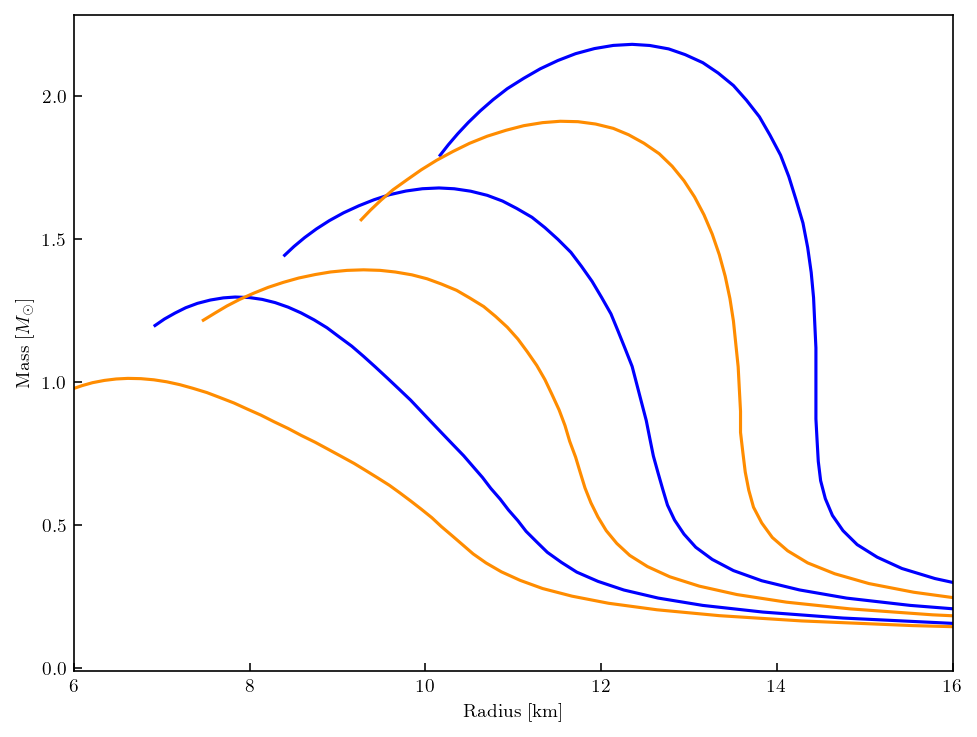

In [505]:
plt.plot(radius_data_mean_20, mass_data_mean_20, color='blue')
plt.plot(radius_data_mean_40, mass_data_mean_40, color='darkorange')
plt.ylabel('Mass [$M_{\odot}$]')
plt.xlabel('Radius [km]')
plt.xlim(6.0, 16.0)
plt.show()

In [147]:
# run the maximum mass and radius for the arrays to save
m_rad, m_pres, m_mass = tov.max_arrays()

# save the radii, pressures, and masses
np.savez('rpm_results_stationary_20n0.npz', radius=radius_data, central_pressure=pressure_data, mass=mass_data, max_radius=m_rad, max_mass=m_mass)

In [205]:
# load the 40n0 results
with open('pres_data_40n0.pkl', 'rb') as fp:
    pressure_dict_40n0 = pickle.load(fp)  # automatically in order of saving
    edens_dict_40n0 = pickle.load(fp)
    cs2_dict_40n0 = pickle.load(fp)

In [206]:
# number of samples
samples_40n0 = len(pressure_dict_40n0['samples'].T)

# TOV data creation (streamlined)
tov_dict_40n0 = tov_data(edens_dict_40n0, pressure_dict_40n0, save=True, \
                    filepath='../data/TOV_data/eos_stationary_40n0.npz')

# run the TOV solver over each sample
mass_data_40n0 = np.zeros([50,samples_40n0])
radius_data_40n0 = np.zeros([50,samples_40n0])
pressure_data_40n0 = np.zeros([50,samples_40n0])

# call the solver once, send all data directly
tov40 = TOVsolver(eos_filepath='../data/TOV_data/eos_stationary_40n0.npz')

# call routine once (should do its thing...check why central pressures are the same for different ones)
radius_data_40n0, pressure_data_40n0, mass_data_40n0 = tov40.tov_routine(verbose=False, write_to_file=False)

Woo it worked!
Radius:  5.5967821496 Maximum mass:  0.8889237124070074 Central pressure:  1884.5046141399623
Radius:  9.1347646328 Maximum mass:  1.5372656379283542 Central pressure:  636.240764772628
Radius:  10.850150079199999 Maximum mass:  1.7416923708724141 Central pressure:  342.0973067434033
Radius:  10.568719654399999 Maximum mass:  1.2181188046946527 Central pressure:  183.94069314768447
Radius:  7.580196572000001 Maximum mass:  1.2438666804281486 Central pressure:  867.6756497154504
Radius:  12.5789369744 Maximum mass:  2.2619804241384394 Central pressure:  342.0973067434033
Radius:  11.0913761576 Maximum mass:  1.6741878604702112 Central pressure:  292.9420362292324
Radius:  8.7059182712 Maximum mass:  1.348040167342951 Central pressure:  544.8206153354404
Radius:  8.732721168800001 Maximum mass:  1.2954642866806172 Central pressure:  544.8206153354404
Radius:  12.806761604 Maximum mass:  2.3798084194548377 Central pressure:  342.0973067434033
Radius:  10.7831428352 Maximum 

Radius:  8.9471443496 Maximum mass:  1.4993398955801567 Central pressure:  636.240764772628
Radius:  7.8348240992000004 Maximum mass:  1.19660733744331 Central pressure:  743.0010894672662
Radius:  9.7512312776 Maximum mass:  1.3934702357933293 Central pressure:  399.5007639993038
Radius:  8.1698603192 Maximum mass:  1.323977784626635 Central pressure:  743.0010894672662
Radius:  6.9905328248 Maximum mass:  1.0530903183697815 Central pressure:  1183.2958131473647
Radius:  12.0562804712 Maximum mass:  1.9921046751441494 Central pressure:  292.9420362292324
Radius:  12.1634920616 Maximum mass:  2.139728949027545 Central pressure:  342.0973067434033
Radius:  6.8967226832 Maximum mass:  1.0852360758515616 Central pressure:  1183.2958131473647
Radius:  9.9522530096 Maximum mass:  1.4972233499145038 Central pressure:  399.5007639993038
Radius:  9.737829828799999 Maximum mass:  1.5622255404719796 Central pressure:  466.5364423805275
Radius:  8.839932759199998 Maximum mass:  1.441918085248204 

Radius:  10.9573616696 Maximum mass:  1.7830342103085066 Central pressure:  342.0973067434033
Radius:  9.6440196872 Maximum mass:  1.4241836185286505 Central pressure:  399.5007639993038
Radius:  11.171784850399998 Maximum mass:  1.8876621204717743 Central pressure:  399.5007639993038
Radius:  8.7997284128 Maximum mass:  1.4004251198658713 Central pressure:  636.240764772628
Radius:  7.137948761600001 Maximum mass:  1.0764971977793585 Central pressure:  1013.2704295883759
Radius:  8.4646921928 Maximum mass:  1.321099545121525 Central pressure:  636.240764772628
Radius:  10.046063151199998 Maximum mass:  1.7615838119584246 Central pressure:  544.8206153354404
Radius:  10.220281985599998 Maximum mass:  1.4478966860059648 Central pressure:  292.9420362292324
Radius:  13.3026152096 Maximum mass:  2.3640501155668283 Central pressure:  292.9420362292324
Radius:  8.183261768000001 Maximum mass:  1.3283723152472626 Central pressure:  743.0010894672662
Radius:  12.806761604 Maximum mass:  2.337

Radius:  5.0205198512 Maximum mass:  0.8551341767362451 Central pressure:  2200.721894819905
Radius:  12.3779152424 Maximum mass:  2.0392337561843705 Central pressure:  292.9420362292324
Radius:  9.871844316799999 Maximum mass:  1.2250904433200316 Central pressure:  250.84978717618554
Radius:  10.046063151199998 Maximum mass:  1.6397936639108095 Central pressure:  466.5364423805275
Radius:  11.4800181728 Maximum mass:  1.8485890547367865 Central pressure:  292.9420362292324
Radius:  9.429596506400001 Maximum mass:  1.4005512584099356 Central pressure:  466.5364423805275
Radius:  7.0039342736000005 Maximum mass:  1.0372522043315964 Central pressure:  1183.2958131473647
Radius:  9.4966037504 Maximum mass:  1.4043065488576985 Central pressure:  466.5364423805275
Radius:  8.1564588704 Maximum mass:  1.3992629282285318 Central pressure:  743.0010894672662
Radius:  10.9841645672 Maximum mass:  1.8260745056496692 Central pressure:  399.5007639993038
Radius:  10.6491283472 Maximum mass:  1.712

Radius:  6.5348835656 Maximum mass:  0.9865515423829537 Central pressure:  1381.8512220680184
Radius:  11.5872297632 Maximum mass:  1.8643780905915108 Central pressure:  292.9420362292324
Radius:  11.2119891968 Maximum mass:  1.7762896487393767 Central pressure:  292.9420362292324
Radius:  10.7027341424 Maximum mass:  1.4836991444205432 Central pressure:  250.84978717618554
Radius:  8.6121081296 Maximum mass:  1.2648240194254583 Central pressure:  636.240764772628
Radius:  8.210064665600001 Maximum mass:  1.3353380084676962 Central pressure:  743.0010894672662
Radius:  11.4800181728 Maximum mass:  1.7316695701916818 Central pressure:  250.84978717618554
Radius:  9.0275530424 Maximum mass:  1.309209226940219 Central pressure:  466.5364423805275
Radius:  9.2821805696 Maximum mass:  1.163054863543149 Central pressure:  292.9420362292324
Radius:  10.2068805368 Maximum mass:  1.373925059400286 Central pressure:  292.9420362292324
Radius:  13.275812312 Maximum mass:  2.528443916433175 Centra

Radius:  9.8182385216 Maximum mass:  1.4618975116596333 Central pressure:  399.5007639993038
Radius:  6.3472632824 Maximum mass:  0.971180065556609 Central pressure:  1183.2958131473647
Radius:  12.8603673992 Maximum mass:  2.384084364113929 Central pressure:  342.0973067434033
Radius:  10.381099371200001 Maximum mass:  1.5806321357316417 Central pressure:  342.0973067434033
Radius:  11.3594051336 Maximum mass:  1.8241411197915507 Central pressure:  342.0973067434033
Radius:  11.774850046400001 Maximum mass:  1.8758294921982785 Central pressure:  292.9420362292324
Radius:  10.3408950248 Maximum mass:  1.568966700715908 Central pressure:  342.0973067434033
Radius:  10.0728660488 Maximum mass:  1.3257360621666558 Central pressure:  292.9420362292324
Radius:  10.1130703952 Maximum mass:  1.3641969851270415 Central pressure:  250.84978717618554
Radius:  13.249009414400001 Maximum mass:  2.415664385095797 Central pressure:  292.9420362292324
Radius:  7.4327806352 Maximum mass:  1.1341148532

In [208]:
# run the maximum mass and radius for the arrays to save
m_rad_40n0, m_pres_40n0, m_mass_40n0 = tov40.max_arrays()

# save the radii, pressures, and masses
np.savez('rpm_results_stationary_40n0.npz', radius=radius_data_40n0, central_pressure=pressure_data_40n0, \
         mass=mass_data_40n0, max_radius=m_rad_40n0, max_mass=m_mass_40n0)

In [209]:
# load the data for the overlay plot
stationary_20 = np.load('rpm_results_stationary_20n0.npz')
stationary_40 = np.load('rpm_results_stationary_40n0.npz')

# separate it all out
radius20n0 = stationary_20['radius']
cpres20n0 = stationary_20['central_pressure']
mass20n0 = stationary_20['mass']
maxrad20n0 = stationary_20['max_radius']
maxmass20n0 = stationary_20['max_mass']

radius40n0 = stationary_40['radius']
cpres40n0 = stationary_40['central_pressure']
mass40n0 = stationary_40['mass']
maxrad40n0 = stationary_40['max_radius']
maxmass40n0 = stationary_40['max_mass']

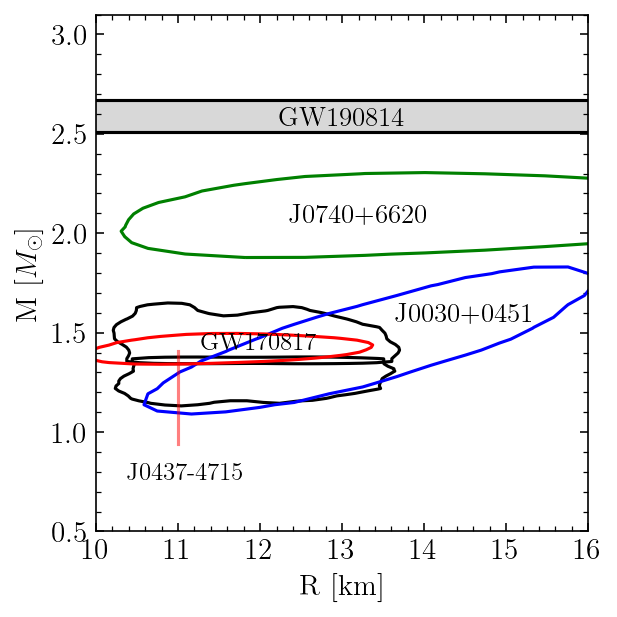

In [373]:
fig = plt.figure(figsize=(4,4), dpi=150)
ax = plt.axes()
corner.hist2d(x11, y11, bins=30, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=1.1, ax=ax, color=None, quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=True, force_range=False)
corner.hist2d(x22, y22, bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=0.9, ax=ax, color=None, quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=True, force_range=False)
corner.hist2d(miller[:,0], miller[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=0.8, ax=ax, color='green', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=True, force_range=False)
corner.hist2d(miller_0030_2[:,0], miller_0030_2[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=0.8, ax=ax, color='blue', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=True, force_range=False)
corner.hist2d(j0437[:,2], j0437[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=j0437[:,0], \
              levels=[0.9], smooth=0.8, ax=ax, color='red', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=True, force_range=False)
ax.text(13.2, 2.15, r'J0740+6620', ha='center', va='top', fontsize=13)
ax.text(14.5, 1.65, r'J0030+0451', ha='center', va='top', fontsize=13)
# GW 190814
fake_linspace = np.linspace(10.0, 16.0, 100)
gw_lower = 2.51*np.ones(len(fake_linspace))
gw_upper = 2.67*np.ones(len(fake_linspace))
ax.fill_between(fake_linspace, gw_lower, gw_upper, alpha=0.3, color='grey')
ax.axhline(y=2.51, color='k')
ax.axhline(y=2.67, color='k')
ax.text(13.0, 2.635, r'GW190814', ha='center', va='top', fontsize=13)
ax.set_ylim(0.5,3.1)
ax.set_xlim(10.0,16.0)
# ax.xaxis.set_major_locator(MultipleLocator(0.25))
ax.tick_params(right=True, top=True, which='both', labelsize=14)
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.set_xlabel(r'R [km]', fontsize=14)
ax.set_ylabel(r'M [$M_{\odot}$]', fontsize=14)
ax.text(12.0, 1.5, r'GW170817', ha='center', va='top', fontsize=12)
ax.axvline(x=11.0, ymin=0.17, ymax=0.35, color='red', alpha=0.5)
ax.text(11.1, 0.85, r'J0437-4715', ha='center', va='top', fontsize=12)
plt.show()
plt.show()

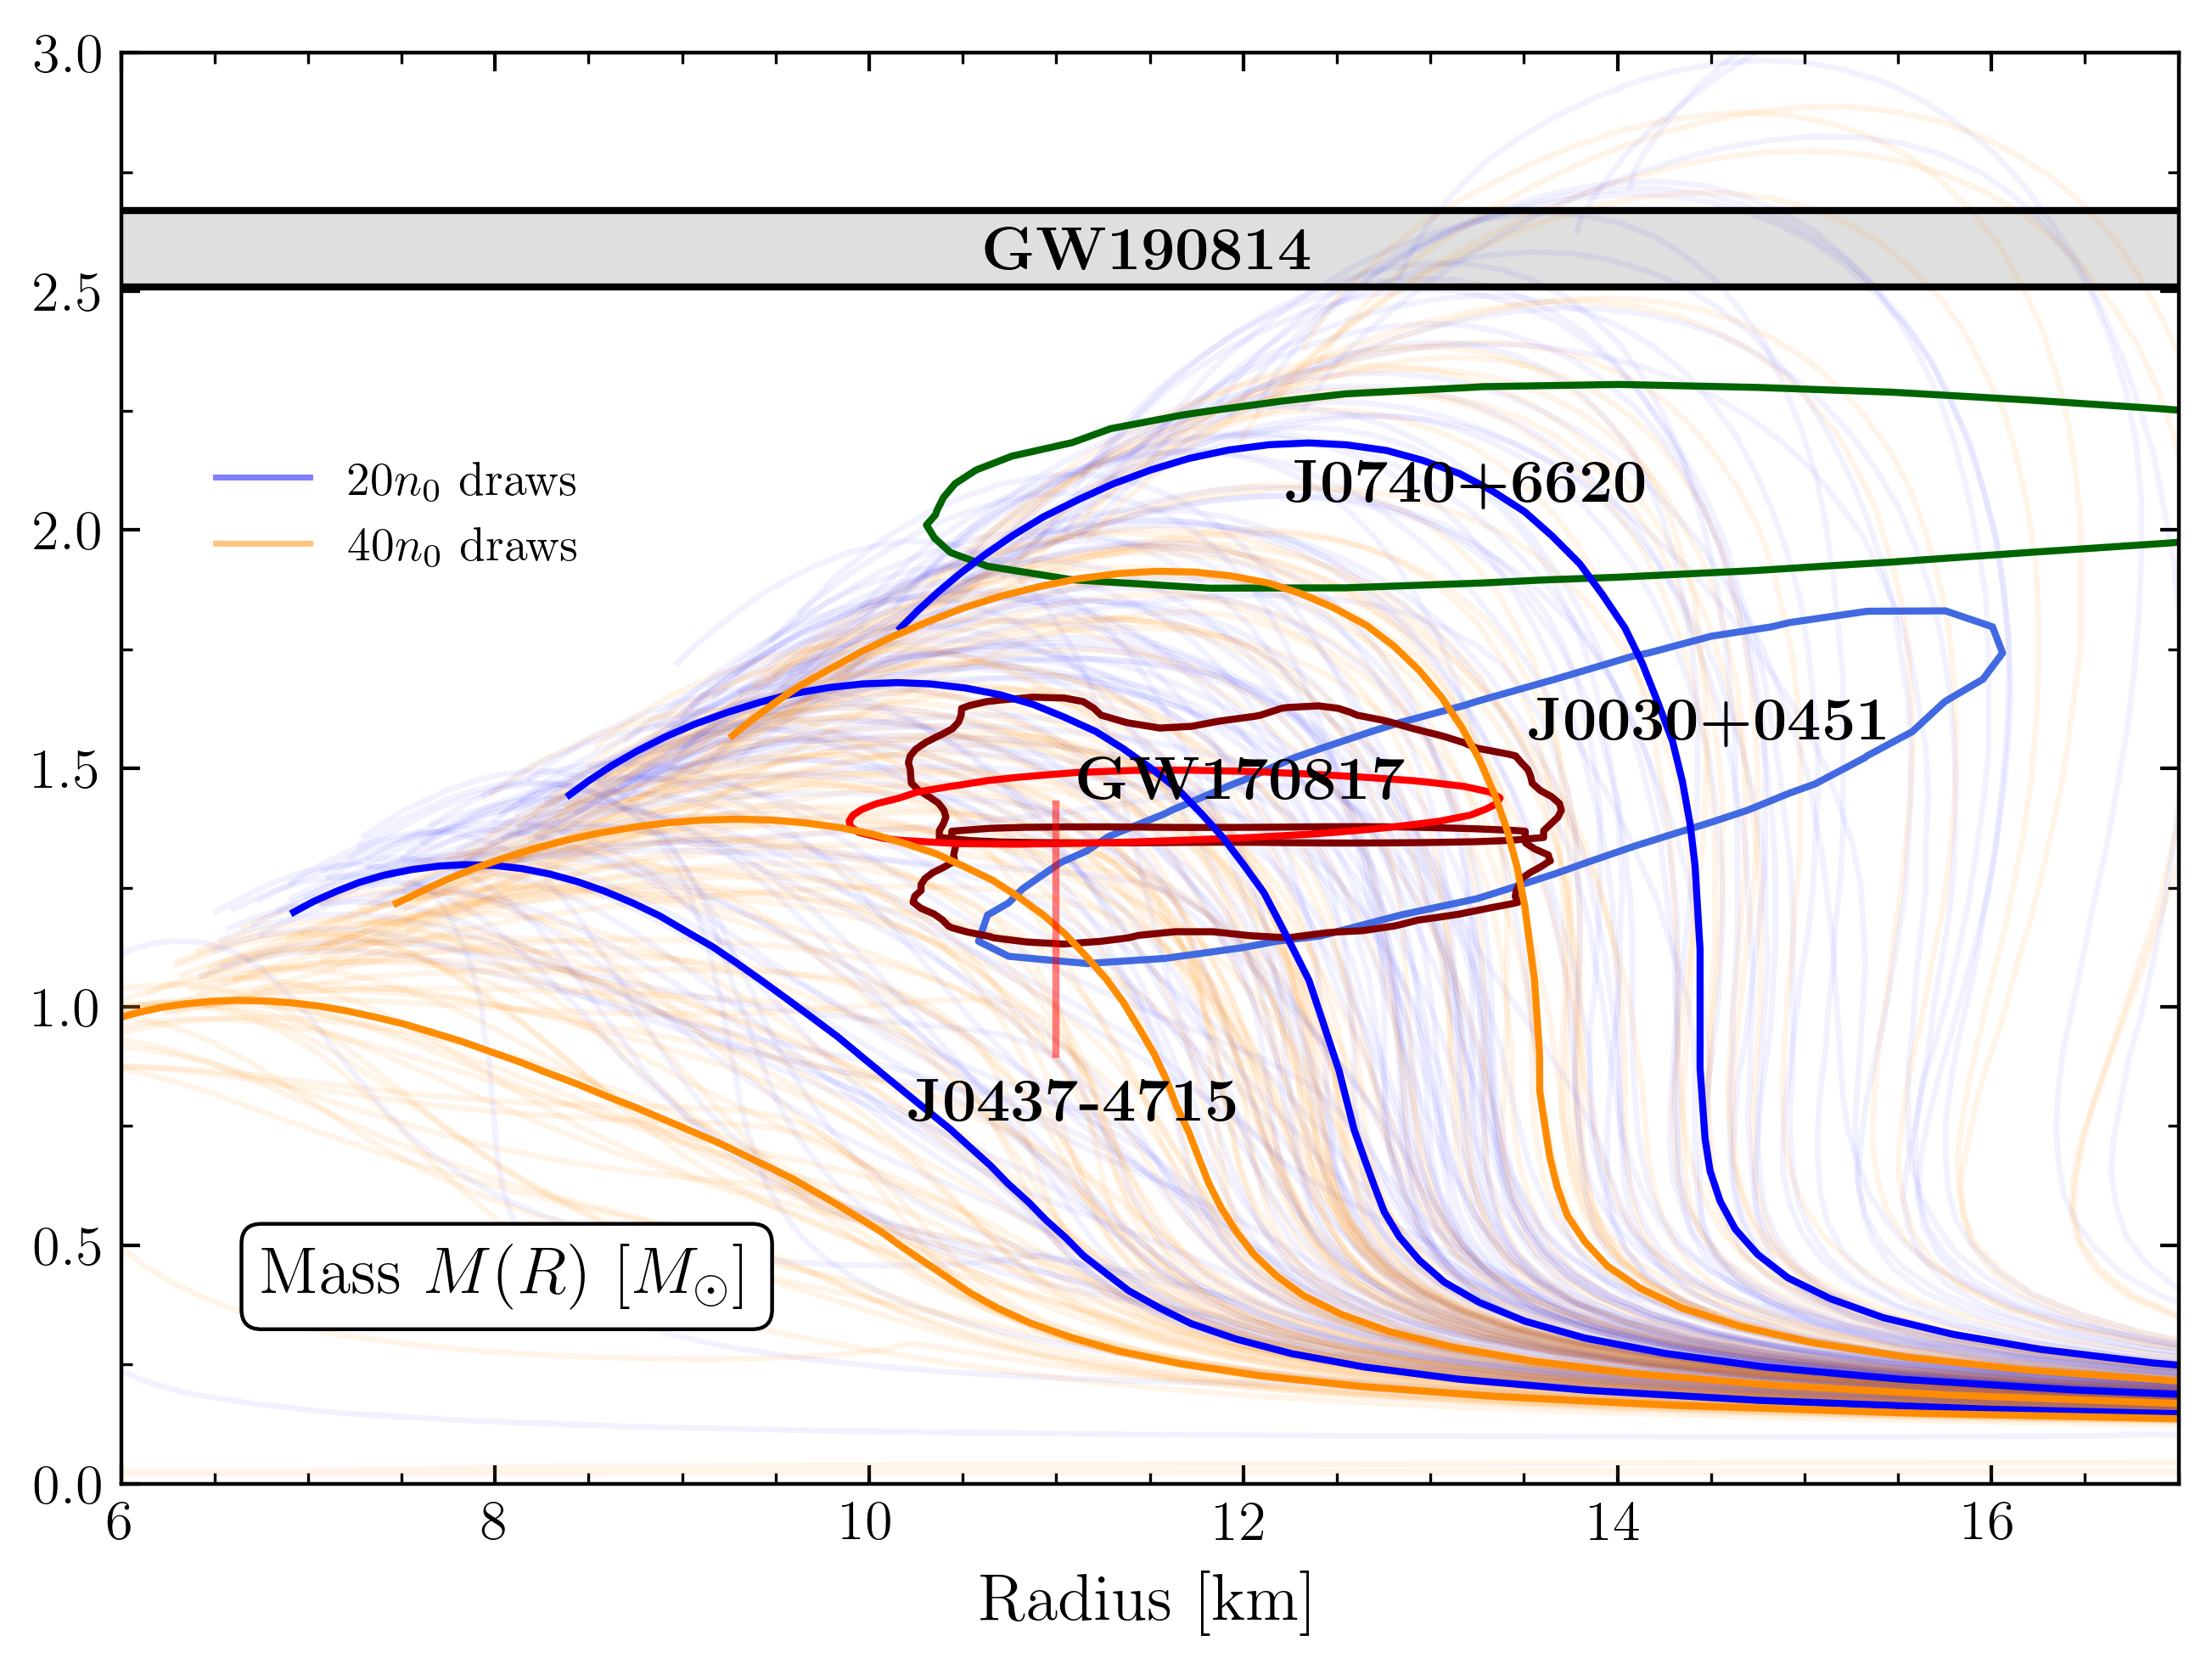

In [507]:
import matplotlib.patches as mpatches

# # define royal purple for contours
#royal_purple = '#9B30FF'

# plot the overall 20n0, 40n0 90% envelope with mean
new_radius_20n0, hpd_interval_20n0 = tov.interval_schwer(fraction=0.9)  # change this!
new_radius_40n0, hpd_interval_40n0 = tov40.interval_schwer(fraction=0.9)  # change this!

# now roughly interpolate the intervals
reduced_radius_curves_20n0, reduced_mass_curves_20n0, curves_dict_20n0 = \
tov.select_curves(new_radius_20n0, maxrad20n0, maxmass20n0, radius20n0, mass20n0, hpd_interval_20n0)

reduced_radius_curves_40n0, reduced_mass_curves_40n0, curves_dict_40n0 = \
tov40.select_curves(new_radius_40n0, maxrad40n0, maxmass40n0, radius40n0, mass40n0, hpd_interval_40n0)

# plot the results including the samples and the overall mean, std_dev
fig, ax = plt.subplots(1,1, dpi=400)
for i in range(len(radius20n0.T)):
    if i % 4 == 0:
        line1, = ax.plot(radius20n0[:,i], mass20n0[:,i], alpha=0.05, color='blue', linewidth=1.25, label=r'$20n_{0}$ draws')
        line2, = ax.plot(radius40n0[:,i], mass40n0[:,i], alpha=0.09, color='darkorange', linewidth=1.25, label=r'$40n_{0}$ draws')

# NICER and LIGO contours
corner.hist2d(miller[:,0], miller[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=0.8, ax=ax, color='darkgreen', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=False)
corner.hist2d(miller_0030_2[:,0], miller_0030_2[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=0.8, ax=ax, color='royalblue', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=False)
corner.hist2d(x11, y11, bins=30, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=1.1, ax=ax, color='maroon', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=False)
corner.hist2d(x22, y22, bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=0.9, ax=ax, color='maroon', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=False)
corner.hist2d(j0437[:,2], j0437[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=j0437[:,0], \
              levels=[0.9], smooth=0.8, ax=ax, color='red', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=False)

# means
# ax.plot(radius_data_mean_20[:,1], mass_data_mean_20[:,1], linestyle='dashdot', color='blue', label=r'$20n_{0}$ mean')
# ax.plot(radius_data_mean_40[:,1], mass_data_mean_40[:,1], linestyle='dashdot', color='darkorange', label=r'$40n_{0}$ mean')
ax.plot(radius_data_mean_20, mass_data_mean_20, color='blue')
ax.plot(radius_data_mean_40, mass_data_mean_40, color='darkorange')
handles, labels = plt.gca().get_legend_handles_labels()

# remove duplicates by converting to a dictionary
unique = dict(zip(labels, handles))
legend = ax.legend(unique.values(), unique.keys(), fontsize=10, frameon=False, bbox_to_anchor=[0.25, 0.6])

for handle in legend.legend_handles:
    handle.set_alpha(0.5)
    
# labels for LIGO and NICER data
ax.text(13.2, 2.15, r'$\textbf{J0740+6620}$', ha='center', va='top', fontsize=13)
ax.text(14.5, 1.65, r'$\textbf{J0030+0451}$', ha='center', va='top', fontsize=13)
# GW 190814
fake_linspace = np.linspace(6.0, 17.0, 100)
gw_lower = 2.51*np.ones(len(fake_linspace))
gw_upper = 2.67*np.ones(len(fake_linspace))
ax.fill_between(fake_linspace, gw_lower, gw_upper, alpha=0.25, color='grey')
ax.axhline(y=2.51, color='k')
ax.axhline(y=2.67, color='k')
ax.text(11.5, 2.635, r'$\textbf{GW190814}$', ha='center', va='top', fontsize=13)
ax.text(12.0, 1.525, r'$\textbf{GW170817}$', ha='center', va='top', fontsize=13, zorder=10)
ax.axvline(x=11.0, ymin=0.30, ymax=0.475, color='red', alpha=0.5)
ax.text(11.1, 0.85, r'$\textbf{J0437-4715}$', ha='center', va='top', fontsize=13)

ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.tick_params(axis='both', which='major', labelsize=12, right=True, top=True)
ax.tick_params(axis='both', which='minor', labelsize=12, right=True, top=True)
ax.set_xlim(6.0, 17.0)
ax.set_ylim(0.0,3.0)
ax.set_xlabel(r'Radius [km]', fontsize=14)
ax.text(6.75, 0.40, r'Mass $M(R)$ $[M_\odot]$', fontsize=14, bbox=dict(facecolor='w', boxstyle='round'))
plt.show()

# corner.hist2d(radius20n0, mass20n0, bins=45, range=None, weights=None, \
#               levels=[0.9], smooth=0.45, ax=ax, color=colors[0], quiet=False, plot_datapoints=False, \
#               plot_density=False, plot_contours=True, no_fill_contours=False, fill_contours=True, \
#               contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
#               new_fig=False)
# corner.hist2d(radius40n0, mass40n0, bins=40, range=None, weights=None, \
#               levels=[0.9], smooth=0.45, ax=ax, color=colors[1], quiet=False, plot_datapoints=False, \
#               plot_density=False, plot_contours=True, no_fill_contours=False, fill_contours=True, \
#               contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
#               new_fig=False)

# extract the contour, see if we can use it for the selection of curves!
# contour_collections = ax.collections
# contours = contour_collections[:2]

# vertices = []
# for contour in contours:
#     for path in contour.get_paths():
#         vertices.append(path.vertices)
        
# vertices_first = np.asarray(vertices)[0]
# plt.plot(vertices_first[:,0], vertices_first[:,1], '.')
# plt.xlim(4.0, 18.0)
# plt.ylim(0.0, 3.0)
# plt.show()

In [289]:
# remove the bad one
radiusb = np.where([radius20n0[:,i] <= 5.5 for i in range(len(radius20n0.T))])[0]
rad_curves = []
for item in radiusb:
    if item not in rad_curves:
        rad_curves.append(item)
#print(rad_curves)

# use these to determine which one
mass_curves = np.zeros([len(radius20n0), len(radius20n0.T)])
for i in rad_curves:
    mass_curves[:,i] = mass20n0[:,i]  
    
    #print(mass_curves[:,i])

radiusb40 = np.where([radius40n0[:,i] <= 4.2 for i in range(len(radius40n0.T))])[0]
rad_curves40 = []
for item in radiusb40:
    if item not in rad_curves40:
        rad_curves40.append(item)

#print(rad_curves40)

# use these to determine which one
mass_curves40 = np.zeros([len(radius40n0), len(radius40n0.T)])
for i in rad_curves40:
    mass_curves40[:,i] = mass40n0[:,i]  
    
#    print(mass_curves40[:,i])

In [ ]:
# add the NICER and LIGO data on top of this result